# Hands On Machine Learning CH.11 심층 신경망 훈련

## 연습문제 8

In [1]:
import tensorflow as tf
import numpy as np
import os
from functools import partial

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

In [2]:
from datetime import datetime

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return"{}/{}/".format(root_logdir, name)

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

X_train1 = X_train[y_train < 5]
y_train1 = y_train[y_train < 5]
X_valid1 = X_valid[y_valid < 5]
y_valid1 = y_valid[y_valid < 5]
X_test1 = X_test[y_test < 5]
y_test1 = y_test[y_test < 5]

In [4]:
tf.reset_default_graph()

n_hidden = 100
n_inputs = 28*28
n_outputs = 5

learning_rate=0.001

he_init = tf.contrib.layers.variance_scaling_initializer()

hidden_layer_100 = partial(tf.layers.dense, units=n_hidden, kernel_initializer=he_init, activation=tf.nn.elu)

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("network"):
    hidden1 = hidden_layer_100(X, name="hidden1")
    hidden2 = hidden_layer_100(hidden1, name="hidden2")
    hidden3 = hidden_layer_100(hidden2, name="hidden3")
    hidden4 = hidden_layer_100(hidden3, name="hidden4")
    hidden5 = hidden_layer_100(hidden4, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, kernel_initializer=he_init, name="logits")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    loss_summary = tf.summary.scalar("log_loss", loss)
    
with tf.name_scope("training"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()
file_writer = tf.summary.FileWriter(log_dir("CH11"), tf.get_default_graph())

In [5]:
#Run

n_epochs = 10001
batch_size = 50

max_epochs_without_progress = 50
epochs_without_progress = 0
best_loss = np.infty

checkpoint_path = "tmp/11. 8_dnn_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "models/11. 8_dnn_model"


with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        with open(checkpoint_epoch_path, 'rb') as f:
            start_epoch = int(f.read())
        print("중지되었던 훈련입니다. 이어서 훈련합니다.", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        init.run()
    for epoch in range(start_epoch, n_epochs):
        rnd_idx = np.random.permutation(len(X_train1))
        for rnd_idices in np.array_split(rnd_idx, len(X_train1) // batch_size):
            X_batch, y_batch = X_train1[rnd_idices], y_train1[rnd_idices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val, loss_val, summary_str = sess.run([accuracy, loss, loss_summary], feed_dict={X:X_valid1, y: y_valid1})
        file_writer.add_summary(summary_str, epoch)
        if epoch % 5 == 0:
            print(epoch, "Train accuracy:", acc_train, "Validation accuracy:", acc_val, "Loss:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch+1))
            if loss_val < best_loss:
                best_loss = loss_val
            else:
                epochs_without_progress += 5
                if epochs_without_progress > max_epochs_without_progress:
                    print("학습 종료")
                    break
    
    save_path = saver.save(sess, final_model_path)
    os.remove(checkpoint_epoch_path)
    
with tf.Session() as sess:
    saver.restore(sess, final_model_path)
    acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
    print("최종 정확도:", acc_test)


0 Train accuracy: 0.96 Validation accuracy: 0.98279905 Loss: 0.050905496
5 Train accuracy: 1.0 Validation accuracy: 0.9843628 Loss: 0.047521077
10 Train accuracy: 1.0 Validation accuracy: 0.9937451 Loss: 0.025883293
15 Train accuracy: 1.0 Validation accuracy: 0.99296325 Loss: 0.02951165
20 Train accuracy: 1.0 Validation accuracy: 0.9921814 Loss: 0.039870024
25 Train accuracy: 1.0 Validation accuracy: 0.9913995 Loss: 0.043114018
30 Train accuracy: 1.0 Validation accuracy: 0.98944485 Loss: 0.04983349
35 Train accuracy: 1.0 Validation accuracy: 0.994527 Loss: 0.038883425
40 Train accuracy: 1.0 Validation accuracy: 0.99296325 Loss: 0.031353764
45 Train accuracy: 1.0 Validation accuracy: 0.994527 Loss: 0.03259209
50 Train accuracy: 1.0 Validation accuracy: 0.9953088 Loss: 0.036789335
55 Train accuracy: 1.0 Validation accuracy: 0.9953088 Loss: 0.040813964
60 Train accuracy: 1.0 Validation accuracy: 0.9953088 Loss: 0.04507263
65 Train accuracy: 1.0 Validation accuracy: 0.9953088 Loss: 0.04954

## 연습문제 9

In [6]:
tf.reset_default_graph()

restore_saver = tf.train.import_meta_graph("models/11. 8_dnn_model.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
loss = tf.get_default_graph().get_tensor_by_name("loss/loss:0")
accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")
logits = tf.get_default_graph().get_tensor_by_name("network/logits/BiasAdd:0")


In [7]:
learning_rate = 0.01
output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="logits")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

loss_summary = tf.summary.scalar("log_loss", loss)
file_writer = tf.summary.FileWriter(log_dir("CH11_9_1"), tf.get_default_graph())

In [8]:
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [9]:
X_train2_full = X_train[y_train >= 5]
y_train2_full = y_train[y_train >= 5] - 5
X_valid2_full = X_valid[y_valid >= 5]
y_valid2_full = y_valid[y_valid >= 5] - 5
X_test2 = X_test[y_test >= 5]
y_test2 = y_test[y_test >= 5] - 5

In [10]:
def sample_n_instances_per_class(X, y, n=100):
    Xs, ys = [], []
    for label in np.unique(y):
        idx = (y == label)
        Xc = X[idx][:n]
        yc = y[idx][:n]
        Xs.append(Xc)
        ys.append(yc)
    return np.concatenate(Xs), np.concatenate(ys)

In [11]:
X_train2, y_train2 = sample_n_instances_per_class(X_train2_full, y_train2_full, n=100)
X_valid2, y_valid2 = sample_n_instances_per_class(X_valid2_full, y_valid2_full, n=30)

In [12]:
#Run

n_epochs = 10001
batch_size = 50

max_epochs_without_progress = 50
epochs_without_progress = 0
best_loss = np.infty

checkpoint_path = "tmp/11. 9_1_dnn_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "models/11. 9_1_dnn_model"


with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        with open(checkpoint_epoch_path, 'rb') as f:
            start_epoch = int(f.read())
        print("중지되었던 훈련입니다. 이어서 훈련합니다.", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        init.run()
    for epoch in range(start_epoch, n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_idices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_idices], y_train2[rnd_idices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val, loss_val, summary_str = sess.run([accuracy, loss, loss_summary], feed_dict={X:X_valid2, y: y_valid2})
        file_writer.add_summary(summary_str, epoch)
        if epoch % 5 == 0:
            print(epoch, "Train accuracy:", acc_train, "Validation accuracy:", acc_val, "Loss:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch+1))
            if loss_val < best_loss:
                best_loss = loss_val
            else:
                epochs_without_progress += 5
                if epochs_without_progress > max_epochs_without_progress:
                    print("학습 종료")
                    break
    
    save_path = saver.save(sess, final_model_path)
    os.remove(checkpoint_epoch_path)
    
with tf.Session() as sess:
    saver.restore(sess, final_model_path)
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 정확도:", acc_test)

0 Train accuracy: 0.66 Validation accuracy: 0.7 Loss: 0.9339136
5 Train accuracy: 0.88 Validation accuracy: 0.8066667 Loss: 0.57316726
10 Train accuracy: 0.84 Validation accuracy: 0.84 Loss: 0.5393415
15 Train accuracy: 0.94 Validation accuracy: 0.8466667 Loss: 0.5369514
20 Train accuracy: 0.9 Validation accuracy: 0.8333333 Loss: 0.5480967
25 Train accuracy: 0.94 Validation accuracy: 0.82 Loss: 0.55014515
30 Train accuracy: 0.92 Validation accuracy: 0.8333333 Loss: 0.5620701
35 Train accuracy: 1.0 Validation accuracy: 0.82 Loss: 0.5773047
40 Train accuracy: 0.92 Validation accuracy: 0.84 Loss: 0.5906904
45 Train accuracy: 0.9 Validation accuracy: 0.8333333 Loss: 0.60866106
50 Train accuracy: 0.96 Validation accuracy: 0.8333333 Loss: 0.61635536
55 Train accuracy: 0.96 Validation accuracy: 0.8333333 Loss: 0.6307665
60 Train accuracy: 0.96 Validation accuracy: 0.8333333 Loss: 0.6514885
65 Train accuracy: 0.98 Validation accuracy: 0.82666665 Loss: 0.6687559
70 Train accuracy: 0.98 Validati

In [13]:
hidden5_out = tf.get_default_graph().get_tensor_by_name("network/hidden5/Elu:0")
file_writer = tf.summary.FileWriter(log_dir("CH11_9_2"), tf.get_default_graph())

In [14]:
#Run

n_epochs = 10001
batch_size = 50

max_epochs_without_progress = 50
epochs_without_progress = 0
best_loss = np.infty

checkpoint_path = "tmp/11. 9_2_dnn_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "models/11. 9_2_dnn_model"


with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        with open(checkpoint_epoch_path, 'rb') as f:
            start_epoch = int(f.read())
        print("중지되었던 훈련입니다. 이어서 훈련합니다.", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        init.run()
        
    hidden_5_train = hidden5_out.eval(feed_dict={X: X_train2, y: y_train2})
    hidden_5_valid = hidden5_out.eval(feed_dict={X: X_valid2, y: y_valid2})
    
    for epoch in range(start_epoch, n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_idices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            h5_batch, y_batch = hidden_5_train[rnd_idices], y_train2[rnd_idices]
            sess.run(training_op, feed_dict={hidden5_out: h5_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={hidden5_out: h5_batch, y: y_batch})
        acc_val, loss_val, summary_str = sess.run([accuracy, loss, loss_summary], feed_dict={hidden5_out: hidden_5_valid, y: y_valid2})
        file_writer.add_summary(summary_str, epoch)
        if epoch % 5 == 0:
            print(epoch, "Train accuracy:", acc_train, "Validation accuracy:", acc_val, "Loss:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch+1))
            if loss_val < best_loss:
                best_loss = loss_val
            else:
                epochs_without_progress += 5
                if epochs_without_progress > max_epochs_without_progress:
                    print("학습 종료")
                    break
    
    save_path = saver.save(sess, final_model_path)
    os.remove(checkpoint_epoch_path)
    
with tf.Session() as sess:
    saver.restore(sess, final_model_path)
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 정확도:", acc_test)

0 Train accuracy: 0.62 Validation accuracy: 0.64 Loss: 1.0881445
5 Train accuracy: 0.68 Validation accuracy: 0.7866667 Loss: 0.67234427
10 Train accuracy: 0.84 Validation accuracy: 0.81333333 Loss: 0.58038753
15 Train accuracy: 0.84 Validation accuracy: 0.8333333 Loss: 0.5531565
20 Train accuracy: 0.84 Validation accuracy: 0.8066667 Loss: 0.54371
25 Train accuracy: 0.84 Validation accuracy: 0.82666665 Loss: 0.5447029
30 Train accuracy: 0.92 Validation accuracy: 0.8466667 Loss: 0.5239546
35 Train accuracy: 0.94 Validation accuracy: 0.85333335 Loss: 0.52610517
40 Train accuracy: 0.9 Validation accuracy: 0.85333335 Loss: 0.5235795
45 Train accuracy: 0.9 Validation accuracy: 0.86 Loss: 0.524925
50 Train accuracy: 0.96 Validation accuracy: 0.85333335 Loss: 0.5191049
55 Train accuracy: 0.94 Validation accuracy: 0.8466667 Loss: 0.51292664
60 Train accuracy: 0.94 Validation accuracy: 0.85333335 Loss: 0.524387
65 Train accuracy: 1.0 Validation accuracy: 0.85333335 Loss: 0.53161776
70 Train accu

In [15]:
tf.reset_default_graph()

restore_saver = tf.train.import_meta_graph("models/11. 8_dnn_model.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")
hidden4_out = tf.get_default_graph().get_tensor_by_name("network/hidden4/Elu:0")
logits = tf.layers.dense(hidden4_out, n_outputs, kernel_initializer=he_init, name="new_logits")

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss = tf.reduce_mean(xentropy)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [16]:
learning_rate = 0.01
output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)
saver = tf.train.Saver()
loss_summary = tf.summary.scalar("log_loss", loss)
file_writer = tf.summary.FileWriter(log_dir("CH11_9_3"), tf.get_default_graph())
init = tf.global_variables_initializer()


In [17]:
#Run

n_epochs = 10001
batch_size = 50

max_epochs_without_progress = 50
epochs_without_progress = 0
best_loss = np.infty

checkpoint_path = "tmp/11. 9_3_dnn_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "models/11. 9_3_dnn_model"


with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        with open(checkpoint_epoch_path, 'rb') as f:
            start_epoch = int(f.read())
        print("중지되었던 훈련입니다. 이어서 훈련합니다.", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        init.run()
        
    hidden_4_train = hidden4_out.eval(feed_dict={X: X_train2, y: y_train2})
    hidden_4_valid = hidden4_out.eval(feed_dict={X: X_valid2, y: y_valid2})
    
    for epoch in range(start_epoch, n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_idices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            h4_batch, y_batch = hidden_4_train[rnd_idices], y_train2[rnd_idices]
            sess.run(training_op, feed_dict={hidden4_out: h4_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={hidden4_out: hidden_4_train, y: y_train2})
        acc_val, loss_val, summary_str = sess.run([accuracy, loss, loss_summary], feed_dict={hidden4_out: hidden_4_valid, y: y_valid2})
        file_writer.add_summary(summary_str, epoch)
        if epoch % 5 == 0:
            print(epoch, "Train accuracy:", acc_train, "Validation accuracy:", acc_val, "Loss:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch+1))
            if loss_val < best_loss:
                best_loss = loss_val
            else:
                epochs_without_progress += 5
                if epochs_without_progress > max_epochs_without_progress:
                    print("학습 종료")
                    break
    
    save_path = saver.save(sess, final_model_path)
    os.remove(checkpoint_epoch_path)
    
with tf.Session() as sess:
    saver.restore(sess, final_model_path)
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 정확도:", acc_test)

0 Train accuracy: 0.652 Validation accuracy: 0.6533333 Loss: 0.9893698
5 Train accuracy: 0.848 Validation accuracy: 0.8 Loss: 0.619732
10 Train accuracy: 0.884 Validation accuracy: 0.84 Loss: 0.5735337
15 Train accuracy: 0.904 Validation accuracy: 0.85333335 Loss: 0.5475281
20 Train accuracy: 0.904 Validation accuracy: 0.8466667 Loss: 0.52696115
25 Train accuracy: 0.926 Validation accuracy: 0.86 Loss: 0.5242251
30 Train accuracy: 0.934 Validation accuracy: 0.86 Loss: 0.51448816
35 Train accuracy: 0.942 Validation accuracy: 0.86 Loss: 0.5210268
40 Train accuracy: 0.948 Validation accuracy: 0.86 Loss: 0.50430024
45 Train accuracy: 0.952 Validation accuracy: 0.8666667 Loss: 0.5016423
50 Train accuracy: 0.96 Validation accuracy: 0.86 Loss: 0.5115117
55 Train accuracy: 0.962 Validation accuracy: 0.85333335 Loss: 0.50982547
60 Train accuracy: 0.956 Validation accuracy: 0.8666667 Loss: 0.5223581
65 Train accuracy: 0.962 Validation accuracy: 0.86 Loss: 0.51177615
70 Train accuracy: 0.966 Valid

In [18]:
tf.reset_default_graph()

restore_saver = tf.train.import_meta_graph("models/11. 8_dnn_model.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")
hidden2_out = tf.get_default_graph().get_tensor_by_name("network/hidden2/Elu:0")
logits = tf.get_default_graph().get_tensor_by_name("network/logits/BiasAdd:0")

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss = tf.reduce_mean(xentropy)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [19]:
learning_rate = 0.01

unfrozen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="hidden[34]|new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name="Adam3")
training_op = optimizer.minimize(loss, var_list=unfrozen_vars)

loss_summary = tf.summary.scalar("log_loss", loss)
file_writer = tf.summary.FileWriter(log_dir("CH11_9_4"), tf.get_default_graph())
init = tf.global_variables_initializer()
two_frozen_saver = tf.train.Saver()

In [20]:
#Run

n_epochs = 10001
batch_size = 50

max_epochs_without_progress = 50
epochs_without_progress = 0
best_loss = np.infty

checkpoint_path = "tmp/11. 9_4_dnn_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "models/11. 9_4_dnn_model"


with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        with open(checkpoint_epoch_path, 'rb') as f:
            start_epoch = int(f.read())
        print("중지되었던 훈련입니다. 이어서 훈련합니다.", start_epoch)
        two_frozen_saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        init.run()
    
    restore_saver.restore(sess, "models/11. 8_dnn_model")
    
    hidden_2_train = hidden2_out.eval(feed_dict={X: X_train2, y: y_train2})
    hidden_2_valid = hidden2_out.eval(feed_dict={X: X_valid2, y: y_valid2})
    print('a')
    
    for epoch in range(start_epoch, n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_idices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            h2_batch, y_batch = hidden_2_train[rnd_idices], y_train2[rnd_idices]
            sess.run(training_op, feed_dict={hidden2_out: h2_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={hidden2_out: hidden_2_train, y: y_train2})
        acc_val, loss_val, summary_str = sess.run([accuracy, loss, loss_summary], feed_dict={hidden2_out: hidden_2_valid, y: y_valid2})
        file_writer.add_summary(summary_str, epoch)
        if epoch % 5 == 0:
            print(epoch, "Train accuracy:", acc_train, "Validation accuracy:", acc_val, "Loss:", loss_val)
            two_frozen_saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch+1))
            if loss_val < best_loss:
                best_loss = loss_val
            else:
                epochs_without_progress += 5
                if epochs_without_progress > max_epochs_without_progress:
                    print("학습 종료")
                    break
    
    save_path = two_frozen_saver.save(sess, final_model_path)
    os.remove(checkpoint_epoch_path)
    
with tf.Session() as sess:
    two_frozen_saver.restore(sess, final_model_path)
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 정확도:", acc_test)

INFO:tensorflow:Restoring parameters from models/11. 8_dnn_model
a
0 Train accuracy: 0.736 Validation accuracy: 0.70666665 Loss: 1.1232697
5 Train accuracy: 0.982 Validation accuracy: 0.91333336 Loss: 0.3534832
10 Train accuracy: 0.998 Validation accuracy: 0.91333336 Loss: 0.4194324
15 Train accuracy: 1.0 Validation accuracy: 0.9 Loss: 0.44094884
20 Train accuracy: 1.0 Validation accuracy: 0.9066667 Loss: 0.4705416
25 Train accuracy: 1.0 Validation accuracy: 0.92 Loss: 0.48326153
30 Train accuracy: 1.0 Validation accuracy: 0.9266667 Loss: 0.49529114
35 Train accuracy: 1.0 Validation accuracy: 0.92 Loss: 0.50706255
40 Train accuracy: 1.0 Validation accuracy: 0.92 Loss: 0.5204517
45 Train accuracy: 1.0 Validation accuracy: 0.92 Loss: 0.53349787
50 Train accuracy: 1.0 Validation accuracy: 0.92 Loss: 0.544478
55 Train accuracy: 1.0 Validation accuracy: 0.92 Loss: 0.5544556
60 Train accuracy: 1.0 Validation accuracy: 0.92 Loss: 0.5630434
학습 종료
INFO:tensorflow:Restoring parameters from model

## 연습문제 10

In [48]:
tf.reset_default_graph()

n_inputs = 28 * 28
n_outputs = 10
learning_rate = 0.001

X = tf.placeholder(tf.float32, shape=(None, 2, n_inputs), name="X1")
X1, X2 = tf.unstack(X, axis=1)
y = tf.placeholder(tf.int64, shape=[None, 1], name="y")

with tf.name_scope("dnn_1"):
    hidden11 = hidden_layer_100(X1, name="hidden11")
    hidden12 = hidden_layer_100(hidden11, name="hidden12")
    hidden13 = hidden_layer_100(hidden12, name="hidden13")
    hidden14 = hidden_layer_100(hidden13, name="hidden14")
    hidden15 = hidden_layer_100(hidden14, name="hidden15")

with tf.name_scope("dnn_2"):
    hidden21 = hidden_layer_100(X2, name="hidden21")
    hidden22 = hidden_layer_100(hidden21, name="hidden22")
    hidden23 = hidden_layer_100(hidden22, name="hidden23")
    hidden24 = hidden_layer_100(hidden23, name="hidden24")
    hidden25 = hidden_layer_100(hidden24, name="hidden25")

with tf.name_scope("output"):
    concat = tf.concat([hidden15, hidden25], axis=1)
    hidden = tf.layers.dense(concat, 10, kernel_initializer=he_init, activation=tf.nn.elu)
    logits = tf.layers.dense(hidden, 1, kernel_initializer=he_init, name="logits")
    y_proba = tf.nn.sigmoid(logits, name="y_proba")
    y_pred = tf.cast(tf.greater_equal(logits, 0), tf.int64)

with tf.name_scope("loss"):
    y_as_float = tf.cast(y, tf.float32)
    xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_as_float, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    loss_summary = tf.summary.scalar("log_loss", loss)
    
with tf.name_scope("training"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.equal(y, y_pred)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()
file_writer = tf.summary.FileWriter(log_dir("CH11_10"), tf.get_default_graph())

In [57]:
X_train1 = X_train
y_train1 = y_train

X_train2 = X_valid
y_train2 = y_valid

X_test = X_test
y_test = y_test

In [40]:
def generate_batch(images, labels, batch_size):
    X = []
    y = []
    while len(X) < (batch_size // 2) :
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if rnd_idx1 != rnd_idx2 and labels[rnd_idx1] == labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([1])
        
    while len(X) < batch_size:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if labels[rnd_idx1] != labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([0])
    
    rnd_idices = np.random.permutation(batch_size)
    
    return np.array(X)[rnd_idices], np.array(y)[rnd_idices]
    

In [41]:
batch_size = 5
X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)

X_batch.shape

(5, 2, 784)

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

(-0.5, 27.5, 139.5, -0.5)

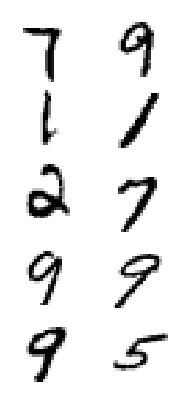

In [43]:
plt.figure(figsize=(3, 3 * batch_size))
plt.subplot(121)
plt.imshow(X_batch[:, 0].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis("off")
plt.subplot(122)
plt.imshow(X_batch[:, 1].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis("off")

In [44]:
y_batch

array([[0],
       [1],
       [0],
       [1],
       [0]])

In [45]:
X_test1, y_test1 = generate_batch(X_test, y_test, batch_size=len(X_test))

In [49]:
n_epochs = 10001
best_loss = np.infty
n_without_progress = 0
max_n_without_progress = 10

batch_size = 500

final_model_path = "models/11. 10_dnn_model"

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(X_train1) // batch_size):
            X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_sum, loss_val, acc_val = sess.run([loss_summary, loss, accuracy], feed_dict={X: X_test1, y: y_test1})
        print(epoch, "Loss:", loss_val, "Accuracy:", acc_val)
        file_writer.add_summary(loss_sum, epoch)
        
        if epoch % 5 == 0 :
            if loss_val < best_loss:
                best_loss = loss_val
            else:
                n_without_progress += 1
                if n_without_progress > max_n_without_progress:
                    break
    
    final_acc = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
    print("Final Accuracy:", final_acc)
    
    save_path = saver.save(sess, final_model_path)

0 Loss: 0.43221885 Accuracy: 0.7946
1 Loss: 0.35233784 Accuracy: 0.8518
2 Loss: 0.27449176 Accuracy: 0.8876
3 Loss: 0.22187886 Accuracy: 0.9136
4 Loss: 0.18677309 Accuracy: 0.9293
5 Loss: 0.18210764 Accuracy: 0.9317
6 Loss: 0.15667255 Accuracy: 0.9409
7 Loss: 0.1297759 Accuracy: 0.9519
8 Loss: 0.122631736 Accuracy: 0.9552
9 Loss: 0.11801486 Accuracy: 0.9573
10 Loss: 0.11044541 Accuracy: 0.9601
11 Loss: 0.10215247 Accuracy: 0.9648
12 Loss: 0.0953427 Accuracy: 0.9678
13 Loss: 0.08792543 Accuracy: 0.9701
14 Loss: 0.08516831 Accuracy: 0.9698
15 Loss: 0.09070891 Accuracy: 0.972
16 Loss: 0.08145917 Accuracy: 0.9726
17 Loss: 0.090520196 Accuracy: 0.9702
18 Loss: 0.0841903 Accuracy: 0.973
19 Loss: 0.07462462 Accuracy: 0.977
20 Loss: 0.07452233 Accuracy: 0.9775
21 Loss: 0.079574615 Accuracy: 0.9747
22 Loss: 0.087946475 Accuracy: 0.9728
23 Loss: 0.07717004 Accuracy: 0.9769
24 Loss: 0.06701691 Accuracy: 0.9797
25 Loss: 0.07005286 Accuracy: 0.9796
26 Loss: 0.07287023 Accuracy: 0.9765
27 Loss: 0.06

In [52]:
tf.reset_default_graph()

n_inputs = 28 * 28
n_outputs = 10
learning_rate = 0.001

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=[None], name="y")

with tf.name_scope("dnn_1"):
    hidden11 = hidden_layer_100(X, name="hidden11")
    hidden12 = hidden_layer_100(hidden11, name="hidden12")
    hidden13 = hidden_layer_100(hidden12, name="hidden13")
    hidden14 = hidden_layer_100(hidden13, name="hidden14")
    hidden15 = hidden_layer_100(hidden14, name="hidden15")
    frozen_hidden = tf.stop_gradient(hidden15)
    
with tf.name_scope("output"):
    logits = tf.layers.dense(frozen_hidden, n_outputs, kernel_initializer=he_init, name="logits")
    y_proba = tf.nn.sigmoid(logits, name="y_proba")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    loss_summary = tf.summary.scalar("log_loss", loss)
    
with tf.name_scope("training"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
init = tf.global_variables_initializer()
dnn_1_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden1")
restore_saver = tf.train.Saver(var_list = {var.op.name: var for var in dnn_1_vars})
saver = tf.train.Saver()
file_writer = tf.summary.FileWriter(log_dir("CH11_10_2"), tf.get_default_graph())

In [59]:
n_epochs = 10001
best_loss = np.infty
n_without_progress = 0
max_n_without_progress = 10

batch_size = 50

restore_model_path = "models/11. 10_dnn_model"
final_model_path = "models/11. 10_2_dnn_model"

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, restore_model_path)
    
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_idices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_idices], y_train2[rnd_idices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_sum, loss_val, acc_val = sess.run([loss_summary, loss, accuracy], feed_dict={X: X_test, y: y_test})
        print(epoch, "Loss:", loss_val, "Accuracy:", acc_val)
        file_writer.add_summary(loss_sum, epoch)
        
        if epoch % 5 == 0 :
            if loss_val < best_loss:
                best_loss = loss_val
            else:
                n_without_progress += 1
                if n_without_progress > max_n_without_progress:
                    break
    
    final_acc = accuracy.eval(feed_dict={X: X_test, y: y_test})
    print("Final Accuracy:", final_acc)
    
    save_path = saver.save(sess, final_model_path)

INFO:tensorflow:Restoring parameters from models/11. 10_dnn_model
0 Loss: 0.2841364 Accuracy: 0.9359
1 Loss: 0.20358536 Accuracy: 0.9587
2 Loss: 0.17913489 Accuracy: 0.965
3 Loss: 0.16574754 Accuracy: 0.9692
4 Loss: 0.15683977 Accuracy: 0.9704
5 Loss: 0.15029614 Accuracy: 0.9714
6 Loss: 0.14674853 Accuracy: 0.9712
7 Loss: 0.1422701 Accuracy: 0.972
8 Loss: 0.13990203 Accuracy: 0.9716
9 Loss: 0.13753776 Accuracy: 0.9721
10 Loss: 0.13507049 Accuracy: 0.9727
11 Loss: 0.13245489 Accuracy: 0.9725
12 Loss: 0.13325194 Accuracy: 0.9732
13 Loss: 0.12932631 Accuracy: 0.9731
14 Loss: 0.12838195 Accuracy: 0.9732
15 Loss: 0.12718216 Accuracy: 0.9728
16 Loss: 0.1274606 Accuracy: 0.9732
17 Loss: 0.1242443 Accuracy: 0.9737
18 Loss: 0.12507296 Accuracy: 0.9736
19 Loss: 0.12359663 Accuracy: 0.9739
20 Loss: 0.1220988 Accuracy: 0.9743
21 Loss: 0.122726746 Accuracy: 0.9736
22 Loss: 0.1218125 Accuracy: 0.9738
23 Loss: 0.12021897 Accuracy: 0.9737
24 Loss: 0.12066365 Accuracy: 0.9737
25 Loss: 0.118903406 Accur

In [60]:
#not_restored

tf.reset_default_graph()

n_inputs = 28 * 28
n_outputs = 10
learning_rate = 0.001

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=[None], name="y")

with tf.name_scope("dnn_1"):
    hidden11 = hidden_layer_100(X, name="hidden11")
    hidden12 = hidden_layer_100(hidden11, name="hidden12")
    hidden13 = hidden_layer_100(hidden12, name="hidden13")
    hidden14 = hidden_layer_100(hidden13, name="hidden14")
    hidden15 = hidden_layer_100(hidden14, name="hidden15")
    
with tf.name_scope("output"):
    logits = tf.layers.dense(hidden15, n_outputs, kernel_initializer=he_init, name="logits")
    y_proba = tf.nn.sigmoid(logits, name="y_proba")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    loss_summary = tf.summary.scalar("log_loss", loss)
    
with tf.name_scope("training"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()
file_writer = tf.summary.FileWriter(log_dir("CH11_10_3"), tf.get_default_graph())

In [62]:
n_epochs = 10001
best_loss = np.infty
n_without_progress = 0
max_n_without_progress = 10

batch_size = 50

final_model_path = "models/11. 10_3_dnn_model"

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_idices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_idices], y_train2[rnd_idices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_sum, loss_val, acc_val = sess.run([loss_summary, loss, accuracy], feed_dict={X: X_test, y: y_test})
        print(epoch, "Loss:", loss_val, "Accuracy:", acc_val)
        file_writer.add_summary(loss_sum, epoch)
        
        if epoch % 5 == 0 :
            if loss_val < best_loss:
                best_loss = loss_val
            else:
                n_without_progress += 1
                if n_without_progress > max_n_without_progress:
                    break
    
    final_acc = accuracy.eval(feed_dict={X: X_test, y: y_test})
    print("Final Accuracy:", final_acc)
    
    save_path = saver.save(sess, final_model_path)

0 Loss: 0.3412308 Accuracy: 0.8941
1 Loss: 0.30026144 Accuracy: 0.9064
2 Loss: 0.25832838 Accuracy: 0.9189
3 Loss: 0.25780922 Accuracy: 0.9213
4 Loss: 0.23832795 Accuracy: 0.9274
5 Loss: 0.23137446 Accuracy: 0.9359
6 Loss: 0.26874304 Accuracy: 0.9302
7 Loss: 0.2931884 Accuracy: 0.9256
8 Loss: 0.32790685 Accuracy: 0.9207
9 Loss: 0.40393725 Accuracy: 0.9096
10 Loss: 0.31849623 Accuracy: 0.9302
11 Loss: 0.30762684 Accuracy: 0.9299
12 Loss: 0.29522055 Accuracy: 0.936
13 Loss: 0.26068005 Accuracy: 0.9442
14 Loss: 0.2541512 Accuracy: 0.9451
15 Loss: 0.25289693 Accuracy: 0.9454
16 Loss: 0.25485116 Accuracy: 0.9458
17 Loss: 0.25479415 Accuracy: 0.946
18 Loss: 0.25684464 Accuracy: 0.9458
19 Loss: 0.2577395 Accuracy: 0.9466
20 Loss: 0.25997987 Accuracy: 0.9466
21 Loss: 0.2604073 Accuracy: 0.9467
22 Loss: 0.26226738 Accuracy: 0.947
23 Loss: 0.26426473 Accuracy: 0.9465
24 Loss: 0.26465216 Accuracy: 0.9469
25 Loss: 0.26678178 Accuracy: 0.9468
26 Loss: 0.26834008 Accuracy: 0.9474
27 Loss: 0.26908422